In [ ]:
# 참조 : https://coredottoday.github.io/2018/09/17/%EB%AA%A8%EB%8D%B8-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0-%ED%8A%9C%EB%8B%9D/

+ **목표** : 리뷰&블로그 내용&CS 자료에 대한 이슈 발굴


+ **방향**
  + unsupervised learning
  + LDA를 통한 분류 진행
  + 1제품에 대해, 전 기간 대상 변화 확인 $\to$ 주차별(weekly) 변화 확인  


+ **확인내용** 
  1. [x] 최적화 : parameter tunning을 통한 개선가능 여부
      + topic 수에 대한 최적화 : 세부 지표별 검증 방법
          + Perlexity : 예측 정확성, 값이 작으면 토픽모델이 문서를 잘 반영된다
          + Coherences : 주제의 일관성, 높을수록 의미론적 일관성 높음  
             $\to$ max(perplexities) / min(coherences)
  2. [ ] 토큰화 : 명사단일 ~ 전체유형으로 자료로 변환해 가면서, 이슈발굴에 유의미한 corpus 대상 결정
  3. [ ] 시각화 : 특정 키워드에 대한 도출가능 여부(필요해?)
  4. [ ] 기간별 정렬 : 기간별로 topic유형의 변화 및 주요 text에 대한 trend 추이 점검  
      $\to$ 네이버 검색추이와 비교(단, 단일검색에 대한 추이만 확인가능) 


In [89]:
# DB접속
import pymysql
import pandas as pd
import numpy as np
import re
import warnings
import json
from glob import glob
import os 
from google.cloud import bigquery


# 그래프
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)

# 한글정제 KoNLPy
from ckonlpy.tag import Twitter
twitter = Twitter()

# gemsime
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim import corpora, models, similarities

from gensim.models import Phrases

import pyLDAvis.gensim


# 시간기록
from datetime import datetime, timedelta
import time 
from dateutil.relativedelta import relativedelta

import warnings
warnings.filterwarnings("ignore")


### 1.데이터 불러오기 : 리뷰

In [11]:
#########
# 2.자료 추출 : BigQuery
###


category_keyword = '어메이징'

start_dt = datetime.strptime('20210915', "%Y%m%d").date().strftime('%Y-%m-%d')
end_dt   = datetime.strptime('20211130', "%Y%m%d").date().strftime('%Y-%m-%d')

# 접속 정보 
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./**************************.json"
client = bigquery.Client()

# 쿼리실행
sql = """SELECT USER
         , FORMAT_DATETIME('%Y-%m-%d', CAST(A.DATE AS DATETIME)) as REG_DTM
         , FORMAT_DATETIME('%Y-%WW', CAST(A.DATE AS DATETIME)) as WEEK
         , CHANNEL
         , PRODUCT
         , REVIEW
         , SCORE
         FROM `thermal-rain-234004.review.review_all` A
         where PRODUCT like '%"""+category_keyword+"""%'
         and CAST(A.DATE AS DATETIME) between PARSE_DATE('%Y-%m-%d', '"""+start_dt+"""') and  PARSE_DATE('%Y-%m-%d', '"""+end_dt+"""')
         order by CAST(A.DATE AS DATETIME) desc"""
df3A = client.query(sql).to_dataframe()
df3A = df3A.replace('kakaomakers', '카카오 선물하기')

In [12]:
###############
# 2.자료 추출 : MySQL
#####


start_dtm = datetime.strptime('20211001', "%Y%m%d").date().strftime('"%Y%m%d"')
end_dtm   = datetime.strptime('20211130', "%Y%m%d").date().strftime('"%Y%m%d"')
category_keyword = '어메이징'


# 접속 정보 
conn = pymysql.connect(host = '**.***.*.*', user ='__USER_ID__', password = "__PASSWORD__", database='__DATABASE__')
cursor = conn.cursor(pymysql.cursors.DictCursor) 

# 관련 함수 
def MySQL_query(start_dtm, end_dtm, category_keyword ):
    sql= '''select A.WRITER as USER
            , (STR_TO_DATE(A.WRITE_DT, '%Y%m%d'))  as REG_DTM 
            , DATE_FORMAT(STR_TO_DATE(A.WRITE_DT, '%Y%m%d'),'%Y-%uW' )  as WEEK 
            , (SELECT CODE_NM FROM JT_CODE B WHERE A.COMPANY_CODE = B.CODE AND B.CODE_GRP_ID = 'DEALER_ID') as CHANNEL 
            , group_concat(distinct B.CODE_NM order by CODE_NM asc) as PRODUCT
            , A.GRADE as SCORE
            , trim(A.CONTENTS) as REVIEW
            FROM MAEIL_REVIEW A, JT_CODE B
            where A.GRADE in (1,2,3,4,5)
            and CAST(STR_TO_DATE(A.WRITE_DT, '%Y%m%d') AS DATETIME) between '''+start_dtm+''' and '''+end_dtm+'''
            and A.PRODUCT_CODE = B.CODE 
            AND B.CODE_NM like '%'''+category_keyword +'''%'
            and B.CODE not like'G_%'
            group by A.WRITER, A.WRITE_DT, A.COMPANY_CODE, GRADE, CONTENTS
            order by A.WRITE_DT desc
            '''
    cursor.execute(sql)
    df_t = cursor.fetchall()
    df_t = pd.DataFrame(df_t)
    df_t['SCORE'] = df_t['SCORE'].astype(float)
    df_t['REG_DTM'] = pd.to_datetime(df_t['REG_DTM'],format = '%Y-%m-%d')
    df_t['REVIEW'] = df_t['REVIEW'].str.replace('\n', ' ')
    df_t['lenght'] = df_t['REVIEW'].str.len()
    return df_t


In [13]:
df3B = MySQL_query(start_dtm, end_dtm, category_keyword)

df3B = df3B[df3B.lenght != 0]
df3B = df3B.reset_index(drop=True)

In [14]:
df3 = pd.concat([df3A, df3B])
df3 = df3.reset_index(drop=True)

In [180]:
df3.tail()

,USER,REG_DTM,WEEK,CHANNEL,PRODUCT,REVIEW,SCORE,lenght,token,token_attribution,token_attribution2
1250,os76****,2021-10-01 00:00:00,2021-39W,3 네이버,"어메이징 오트 [ 언스위트 ] [ 190ML ],어메이징 오트 [ 오리지널 ] [ ...",오트 밀크라기보단 달지 않은 두유같아요 그래도 맛있음,5.0,29.0,오트 밀크 라기보단 달 지 않다 두유 같다 그래도 맛있다,"[오트/Noun, 밀크/Noun, 라기보단/Josa, 달/Noun, 지/Josa, ...",오트/Noun 밀크/Noun 라기보단/Josa 달/Noun 지/Josa 않다/Ver...
1251,sm0*****,2021-10-01 00:00:00,2021-39W,2 11번가,어메이징 오트 [ 오리지널 ] [ 190ML ],신랑이좋아해요,4.0,7.0,신랑 이 좋다 아해 요,"[신랑/Noun, 이/Josa, 좋다/Adjective, 아해/Noun, 요/Josa]",신랑/Noun 이/Josa 좋다/Adjective 아해/Noun 요/Josa
1252,ssun****,2021-10-01 00:00:00,2021-39W,3 네이버,"어메이징 오트 [ 언스위트 ] [ 190ML ],어메이징 오트 [ 오리지널 ] [ ...",생각보다 좀 묽어요 ^^;;,4.0,15.0,생각 보다 좀 묽다 어요,"[생각/Noun, 보다/Josa, 좀/Noun, 묽다/Adjective, 어요/No...",생각/Noun 보다/Josa 좀/Noun 묽다/Adjective 어요/Noun ^^...
1253,tngu****,2021-10-01 00:00:00,2021-39W,3 네이버,"어메이징 오트 [ 언스위트 ] [ 190ML ],어메이징 오트 [ 오리지널 ] [ ...",배송도 빠르고 맛도 있네요 밍밍하는 분들이 있어서 걱정했는데 약간 그렇긴한데 크게 ...,5.0,61.0,배송 도 빠르다 맛 도 있다 밍밍 하다 분 들 이 있다 어서 걱정 하다 약간 그렇다...,"[배송/Noun, 도/Josa, 빠르다/Adjective, 맛/Noun, 도/Jos...",배송/Noun 도/Josa 빠르다/Adjective 맛/Noun 도/Josa 있다/...
1254,wkd******,2021-10-01 00:00:00,2021-39W,2 11번가,어메이징 오트 [ 오리지널 ] [ 190ML ],맛은 조금 없다고하시는데 그래도 건강생각해어 부모님 챙겨드리려고 구매했어요~,4.0,42.0,맛 은 조금 없다 고하 시 는 데 그래도 건강 생각 해 어 부모님 챙기다 드리다 려...,"[맛/Noun, 은/Josa, 조금/Noun, 없다/Adjective, 고하/Nou...",맛/Noun 은/Josa 조금/Noun 없다/Adjective 고하/Noun 시/N...


In [138]:
df3.groupby('WEEK')['USER'].count()

WEEK
2021-37W     23
2021-38W     21
2021-39W     93
2021-40W    149
2021-41W    130
2021-42W    126
2021-43W    205
2021-44W    120
2021-45W    142
2021-46W    120
2021-47W    108
2021-48W     18
Name: USER, dtype: int64

In [56]:
###############
# Text 정제
#####

# 사전에 고유 명사 추가
twitter.add_dictionary('콜드브루', 'Noun')
twitter.add_dictionary('무설탕', 'Noun')
twitter.add_dictionary('오트밀크', 'Noun')
twitter.add_dictionary('종이빨대', 'Noun')
twitter.add_dictionary('프로틴', 'Noun')
twitter.add_dictionary('보냉백', 'Noun')
twitter.add_dictionary('라방', 'Noun')
twitter.add_dictionary('재구매', 'Noun')
twitter.add_dictionary('유통기한', 'Noun')
twitter.add_dictionary('서울우유', 'Noun')
twitter.add_dictionary('매일두유', 'Noun')
twitter.add_dictionary('사은품', 'Noun')
twitter.add_dictionary('어메이징 오트', 'Noun')
twitter.add_dictionary('언스위트', 'Noun')
twitter.add_dictionary('아몬드브리즈', 'Noun')
twitter.add_dictionary('아몬드 브리즈', 'Noun')
twitter.add_dictionary('오리지널', 'Noun')
twitter.add_dictionary('오리지날', 'Noun')
twitter.add_dictionary('재구매', 'Noun')
twitter.add_dictionary('언스윗트', 'Noun')
twitter.add_dictionary('의향', 'Noun')
twitter.add_dictionary('2FL', 'Noun')


def tokenize(doc):
    result = ['/'.join(t) for t in twitter.pos(doc, norm=True, stem=True)] # ex '더빙/Norm', '나다/Verb'
    return result 

def listToString(s):  
    str1 = ""  
    for ele in s:  
        str1 += " " + ele.strip()  
    return str1


In [57]:
# #토큰화 : 전체리뷰자료
# df_temp1 = df3['REVIEW'].replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# # regex to konlpy
# # token_all = [list(dict.fromkeys(tokenize(row))) for row in df_temp1]
# token_all = [list(tokenize(row)) for row in df_temp1]

# data_trim2 = []
# for i in range(len(df_temp1)):
#     t = ' '.join(token_all[i])
#     data_trim2.append(t.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]",""))
    
# df_temp1 = pd.DataFrame(data_trim2)
# df_temp1 = df_temp1[0].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# df3['token'] = df_temp1
# df3['token_attribution'] = token_all
# # df1['lenght'] = df['token_attribution'].str.len()
# df3['token_attribution2'] = data_trim2

In [71]:
def tokenize_korean_text(text):
    text = re.sub(r'[^,.?!\w\s]','', text)
    Okt_morphs = twitter.pos(text)
    words = []
    for word, pos in Okt_morphs:
        if pos == 'Adjective' or pos == 'Verb' or pos == 'Noun':
            words.append(word)
    ## word를 이어붙인 string 형태가 아닌 word의 list를 return해주는 게 sklearn lda 준비 과정과의 차이
    return words

tokenized_list = []

for text in df3['REVIEW']:
    tokenized_list.append(tokenize_korean_text(text))

In [81]:
# text가 비어있는 list 제거
for text in tokenized_list:
    if len(text) <= 0 :
        del tokenized_list[tokenized_list.index(text)]
#         del tokenized_list[i]

In [90]:
bigram = Phrases(tokenized_list, min_count=4, threshold=10)
bigram_mod = Phraser(bigram)

In [91]:
words_bigram = [bigram_mod[doc] for doc in tokenized_list]

In [92]:
dictionary = corpora.Dictionary(tokenized_list)
corpus = [dictionary.doc2bow(text) for text in words_bigram]

In [187]:
# 사전에 등록된 단어 수
len(dictionary)

2750

### 1. Parameter 최적화

In [206]:
# passes에 대한 조정 / topic 수 고정

coherences=[]
perplexities=[]
passes=[]
warnings.filterwarnings('ignore')

for i in range(0, 200, 5):
    ntopics, nwords = 100, 2000
    if i==0:
        p=1
    else:
        p=i
    tic = time.time()
    lda4 = LdaModel(corpus, id2word=dictionary, num_topics=ntopics,  chunksize = nwords, iterations=2000, passes=p)
    print('epoch',p,time.time() - tic)
    # tfidf, corpus 무슨 차이?
    # lda = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=ntopics, iterations=200000)

    cm = CoherenceModel(model=lda4, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    print("Cpherence",coherence)
    coherences.append(coherence)
    print('Perplexity: ', lda4.log_perplexity(corpus),'\n')
    perplexities.append(lda4.log_perplexity(corpus))

epoch 1 0.3235461711883545
Cpherence -3.6464179646395247
Perplexity:  -15.760071607941105 

epoch 5 2.1912789344787598
Cpherence -3.9566239218347117
Perplexity:  -16.085489643804653 

epoch 10 3.431104898452759
Cpherence -3.667980351364828
Perplexity:  -15.46938401788684 

epoch 15 4.184823036193848
Cpherence -3.9976133670932823
Perplexity:  -15.843677386471851 

epoch 20 7.221015214920044
Cpherence -3.4169115074899947
Perplexity:  -16.761539792325255 

epoch 25 8.957480907440186
Cpherence -3.889898052329462
Perplexity:  -16.471903825499098 

epoch 30 21.10311794281006
Cpherence -3.5517797548861694
Perplexity:  -16.80535397932776 

epoch 35 12.596894979476929
Cpherence -3.660479207337876
Perplexity:  -16.25344929975307 

epoch 40 11.786682605743408
Cpherence -3.4370449235747906
Perplexity:  -16.140419667156458 

epoch 45 11.711755514144897
Cpherence -3.7647297902935914
Perplexity:  -16.763284166122435 

epoch 50 18.73894691467285
Cpherence -3.7434691841180414
Perplexity:  -15.846294492

In [216]:
print(corpus[1])

[(5, 1), (8, 1), (50, 1)]


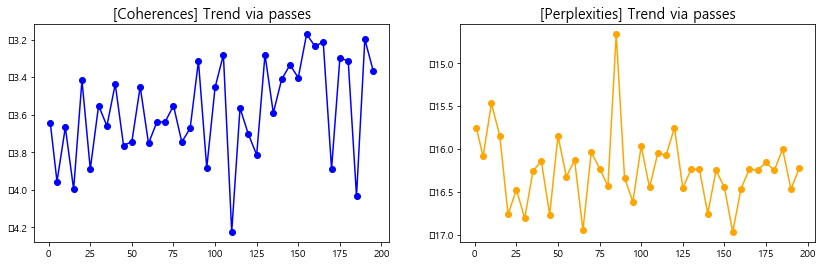

In [213]:
# epoch = [1,5,10,15,20,25,30,35,40,45]
epoch = []
for i in range(0, 200, 5):
    if i==0:
        i=1
    epoch.append(i)


fig = plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epoch, coherences, marker="o", color= 'blue', label='coherences')
plt.title('[Coherences] Trend via passes',fontsize='x-large')

plt.subplot(1,2,2)
plt.plot(epoch, perplexities, marker="o", color= 'orange', label='perplexities')
plt.title('[Perplexities] Trend via passes',fontsize='x-large')

plt.show()

In [183]:
num_topics = 10      # 가설로 잡은 토픽의 갯수
chunksize = 2000     # 훈련 덩어리당 문서의 개수
passes = 10          # 학습 빈도, epochs과 같은 용어임, 최적화 결과수치를 사용함 
iterations = 400     # 각각 문서에 대해서 루프 횟수

In [184]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, 
                                           num_topics = num_topics,
                                           chunksize = chunksize,
                                           passes=passes,
                                           iterations = iterations)


In [185]:
topics = ldamodel.print_topics(num_words=4)
topics

[(0, '0.007*"달" + 0.007*"합니다" + 0.007*"잘" + 0.007*"담"'),
 (1, '0.014*"어요" + 0.009*"저렴" + 0.007*"좋아요" + 0.006*"입니다"'),
 (2, '0.060*"좋아요" + 0.013*"우유" + 0.011*"어요" + 0.008*"대용"'),
 (3, '0.024*"어요" + 0.015*"좋아요" + 0.011*"굿" + 0.011*"했"'),
 (4, '0.020*"맛" + 0.008*"좋습니다" + 0.008*"같아요" + 0.005*"합니다"'),
 (5, '0.031*"맛" + 0.015*"생각" + 0.015*"고소" + 0.007*"요"'),
 (6, '0.014*"어요" + 0.009*"달" + 0.009*"있" + 0.009*"건강"'),
 (7, '0.011*"종이" + 0.009*"때" + 0.009*"빨대" + 0.009*"종류"'),
 (8, '0.015*"두유" + 0.010*"어요" + 0.008*"구매" + 0.008*"기사"'),
 (9, '0.012*"고소" + 0.011*"잘" + 0.009*"아몬드" + 0.009*"도착"')]

In [158]:
from gensim import corpora, models, similarities
cm = CoherenceModel(model=ldamodel, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print("Cpherence",coherence)
print('\nPerplexity: ', ldamodel.log_perplexity(corpus))

Cpherence -12.89426410128561

Perplexity:  -7.813557610519884


In [159]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

In [225]:
def get_keyword(keyword, gubun):
    df3.loc[(df3['token'].str.contains(str(keyword))), 'KEYWORD'] = keyword
    df3.loc[(df3['KEYWORD'] ==keyword), 'GROUP'] = gubun
    
get_keyword('아침', '아침')

In [227]:
df3[df3['GROUP']=='아침'].groupby(['WEEK'])['REVIEW'].count()

WEEK
2021-38W     2
2021-39W     6
2021-40W    17
2021-41W    11
2021-42W     4
2021-43W    13
2021-44W    10
2021-45W    10
2021-46W     7
2021-47W     8
Name: REVIEW, dtype: int64

In [228]:
df3.groupby(['WEEK'])['REVIEW'].count()

WEEK
2021-37W     23
2021-38W     21
2021-39W     93
2021-40W    149
2021-41W    130
2021-42W    126
2021-43W    205
2021-44W    120
2021-45W    142
2021-46W    120
2021-47W    108
2021-48W     18
Name: REVIEW, dtype: int64

In [160]:
df3_t0 = df3[df3['WEEK']=='2021-47W']

tokenized_list_t0 = []

for text in df3_t0['REVIEW']:
    tokenized_list_t0.append(tokenize_korean_text(text))
    
# text가 비어있는 list 제거
for text in tokenized_list_t0:
    if len(text) <= 0 :
        del tokenized_list_t0[tokenized_list_t0.index(text)]

bigram_t0 = Phrases(tokenized_list_t0, min_count=4, threshold=10)
bigram_mod_t0 = Phraser(bigram)

words_bigram_t0 = [bigram_mod[doc] for doc in tokenized_list_t0]

corpus_t0 = [dictionary.doc2bow(text) for text in words_bigram_t0]

ldamodel_t0 = gensim.models.ldamodel.LdaModel(corpus_t0, id2word=dictionary, 
                                           num_topics = num_topics,
                                           chunksize = chunksize,
                                           passes=passes,
                                           iterations = iterations)

In [164]:
topics_t0 = ldamodel_t0.print_topics(num_words=4)
topics_t0

[(0, '0.007*"잘" + 0.007*"팩" + 0.007*"구" + 0.007*"했"'),
 (1, '0.016*"맛" + 0.013*"어요" + 0.011*"있" + 0.011*"아몬드"'),
 (2, '0.015*"어요" + 0.011*"우유" + 0.009*"먹" + 0.006*"요"'),
 (3, '0.011*"맛" + 0.011*"때" + 0.008*"종이" + 0.008*"어요"'),
 (4, '0.051*"좋아요" + 0.016*"어요" + 0.011*"않고" + 0.011*"좋습니다"'),
 (5, '0.019*"맛" + 0.017*"좋아요" + 0.009*"아침" + 0.006*"만족"'),
 (6, '0.014*"맛" + 0.012*"생각" + 0.009*"합니다" + 0.009*"두유"'),
 (7, '0.007*"빨대" + 0.007*"종이" + 0.007*"구입" + 0.004*"맛있네요"'),
 (8, '0.009*"좋아요" + 0.009*"맛" + 0.006*"시켜" + 0.006*"전"'),
 (9, '0.015*"어요" + 0.012*"받았" + 0.012*"요" + 0.009*"고소"')]

In [165]:
# 평가 수치 확인/출력
cm = CoherenceModel(model=ldamodel_t0, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print("Coherence",coherence)
print('\nPerplexity: ', ldamodel_t0.log_perplexity(corpus_t0))

Coherence -11.275135793760864

Perplexity:  -7.8511726027067885


In [166]:
# 시각화 결과 출력/저장
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel_t0, corpus_t0, dictionary)
pyLDAvis.display(vis)

In [167]:
df3_t1 = df3[df3['WEEK']=='2021-46W']

tokenized_list_t1 = []

for text in df3_t1['REVIEW']:
    tokenized_list_t1.append(tokenize_korean_text(text))
    
# text가 비어있는 list 제거
for text in tokenized_list_t1:
    if len(text) <= 0 :
        del tokenized_list_t1[tokenized_list_t1.index(text)]

bigram_t1 = Phrases(tokenized_list_t1, min_count=4, threshold=10)
bigram_mod_t1 = Phraser(bigram)

words_bigram_t1 = [bigram_mod[doc] for doc in tokenized_list_t1]

corpus_t1 = [dictionary.doc2bow(text) for text in words_bigram_t1]

ldamodel_t1 = gensim.models.ldamodel.LdaModel(corpus_t1, id2word=dictionary, 
                                           num_topics = num_topics,
                                           chunksize = chunksize,
                                           passes=passes,
                                           iterations = iterations)

In [168]:
topics_t1 = ldamodel_t1.print_topics(num_words=4)
topics_t1

[(0, '0.016*"좋아요" + 0.005*"오트" + 0.005*"라떼" + 0.005*"것"'),
 (1, '0.021*"맛" + 0.013*"건강" + 0.006*"있" + 0.006*"어보"'),
 (2, '0.016*"우유" + 0.008*"어요" + 0.008*"매일유업" + 0.008*"건강"'),
 (3, '0.059*"좋아요" + 0.010*"했" + 0.010*"구매" + 0.010*"어요"'),
 (4, '0.007*"아몬드" + 0.007*"처음" + 0.007*"선물" + 0.007*"잘"'),
 (5, '0.023*"맛" + 0.010*"종이" + 0.008*"어요" + 0.008*"빨대"'),
 (6, '0.011*"좋아요" + 0.011*"달" + 0.006*"매번" + 0.006*"오트"'),
 (7, '0.022*"어요" + 0.013*"구매" + 0.011*"잘" + 0.009*"했"'),
 (8, '0.016*"합니다" + 0.008*"맛" + 0.008*"만족" + 0.006*"두유"'),
 (9, '0.028*"맛" + 0.016*"요" + 0.012*"두유" + 0.010*"것"')]

In [179]:
# 평가 수치 확인/출력
cm = CoherenceModel(model=ldamodel_t1, corpus=corpus_t1, coherence='u_mass')
coherence = cm.get_coherence()
print('text count',len(df3_t1))
print("\nCpherence",coherence)
print('\nPerplexity: ', ldamodel_t1.log_perplexity(corpus_t1))

text count 120
Cpherence -12.892132298573932

Perplexity:  -7.832391368744356


In [170]:
# 시각화 결과 출력/저장
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel_t1, corpus_t1, dictionary)
pyLDAvis.display(vis)

In [171]:
df3_t2 = df3[df3['WEEK']=='2021-45W']

tokenized_list_t2 = []

for text in df3_t2['REVIEW']:
    tokenized_list_t2.append(tokenize_korean_text(text))
    
# text가 비어있는 list 제거
for text in tokenized_list_t2:
    if len(text) <= 0 :
        del tokenized_list_t2[tokenized_list_t2.index(text)]

bigram_t2 = Phrases(tokenized_list_t2, min_count=4, threshold=10)
bigram_mod_t2 = Phraser(bigram)

words_bigram_t2 = [bigram_mod[doc] for doc in tokenized_list_t2]

corpus_t2 = [dictionary.doc2bow(text) for text in words_bigram_t2]

ldamodel_t2 = gensim.models.ldamodel.LdaModel(corpus_t2, id2word=dictionary, 
                                           num_topics = num_topics,
                                           chunksize = chunksize,
                                           passes=passes,
                                           iterations = iterations)

In [172]:
topics_t2 = ldamodel_t2.print_topics(num_words=4)
topics_t2

[(0, '0.012*"어요" + 0.009*"잘" + 0.009*"있" + 0.006*"배송"'),
 (1, '0.012*"좋아요" + 0.009*"맛" + 0.006*"달" + 0.006*"고소"'),
 (2, '0.021*"어요" + 0.017*"맛" + 0.014*"잘" + 0.012*"고소"'),
 (3, '0.016*"어요" + 0.012*"고소" + 0.012*"좋아요" + 0.010*"아몬드"'),
 (4, '0.019*"좋아요" + 0.016*"맛" + 0.008*"같아요" + 0.008*"빨대"'),
 (5, '0.036*"좋아요" + 0.017*"달" + 0.011*"빨대" + 0.009*"요"'),
 (6, '0.017*"잘" + 0.015*"먹겠습니다" + 0.014*"아몬드" + 0.010*"감사"'),
 (7, '0.014*"두유" + 0.009*"구매" + 0.009*"않아서" + 0.006*"어요"'),
 (8, '0.029*"맛" + 0.020*"어요" + 0.011*"먹" + 0.009*"두유"'),
 (9, '0.020*"받았습니다" + 0.007*"방금" + 0.004*"함" + 0.004*"다음"')]

In [178]:
# 평가 수치 확인/출력
cm = CoherenceModel(model=ldamodel_t2, corpus=corpus_t2, coherence='u_mass')
coherence = cm.get_coherence()
print('text count',len(df3_t2))
print("\nCpherence",coherence)
print('\nPerplexity: ', ldamodel_t2.log_perplexity(corpus_t2))

text count 142

Cpherence -11.476286323196945

Perplexity:  -7.710632218548298
